<h1> TP6: Generative Adversarial Networks</h1>

Ce TP est consacrÃ© Ã  la manipulation de rÃ©seaux gÃ©nÃ©ratifs exploitant le paradigme d'apprentissage "Adversarial". Ce type de rÃ©seaux comprend une partie "GÃ©nÃ©rateur" et une autre "Discriminateur", chacun ayant des objectifs antagonistes. 

La premiÃ¨re partie de ce TP illustre la capacitÃ© des GAN sur des donnÃ©es artificielles, sous la forme d'un mÃ©lange de gaussiennes 1D. Cette partie est fortement guidÃ©e et met en Ã©vidence la capacitÃ© des deux sous rÃ©seaux pour parvenir Ã  approcher au mieux la distribution sous jacentes des donnÃ©es.

La deuxiÃ¨me partie nÃ©cessite un travail en autonomie. Elle consiste Ã  Ã©tendre le rÃ©seau prÃ©alablement dÃ©finie pour, cette fois, modÃ©liser la distribution des donnÃ©es issues du jeu de donnÃ©es MNIST (les chiffres manuscrits).

Pour finir, vous pourriez vous amuser et gÃ©nÃ©rer des visages rÃ©alistes Ã  partir du jeu de donnÃ©es CelebA.

In [1]:
import keras
import keras.backend as K
import numpy as np

<h2>Partie 1: GANs avec des donnÃ©es artificielles</h2>

Dans la cellule suivante, on crÃ©Ã© des donnÃ©es artificielles Ã  partir de distributions gaussiennes. Par la suite, on modifiera le code pour obtenir des donnÃ©es multimodales (ie: mÃ©lange de gaussinnes).

In [2]:
batch_size = 10
nbdata = 250
data_dim = 3 # 1-dimensional data

#xdata = np.random.normal(5, 0.1, (nbdata, data_dim))
xdata1 = np.random.normal(5, 0.1, (int(nbdata/3), data_dim))
xdata2 = np.random.normal(10, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
xdata3 = np.random.normal(15, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
xdata = np.concatenate((xdata1, xdata2, xdata3), axis=0) # for multimodal data
np.random.shuffle(xdata)


Affichage de la densitÃ© de distribution correspondant Ã  nos donnÃ©es :

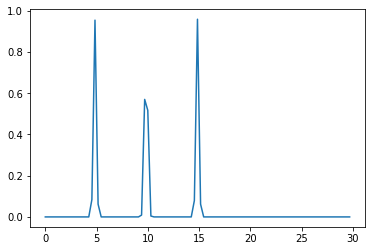

In [3]:
import matplotlib.pyplot as plt

xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)
plt.plot(xs, hx)

<h2>CrÃ©ation d'un gÃ©nÃ©rateur python pour accÃ©der aux donnÃ©es par batch</h2>

In [4]:
def get_batch():
  i = 0
  while True:
    i = i + batch_size
    if i+batch_size > nbdata: 
      i = 0 
    yield xdata[i:i+batch_size].reshape((batch_size, data_dim))

data_generator = get_batch()
x = next(data_generator)
print(x)

[[ 4.93263465  4.93069016  5.01193264]
 [15.11989577 15.14309506 14.90426576]
 [ 4.94555862  5.06915748  5.09193484]
 [10.0535406   9.99869185  9.94353398]
 [ 4.83250602  4.93975604  4.97352852]
 [15.11704428 14.90379167 15.1678115 ]
 [10.32314046  9.92727722 10.03262379]
 [ 5.18243154  5.05533978  4.95102092]
 [ 5.10726703  5.14162902  4.92011392]
 [ 9.99140247 10.00357113  9.84197953]]


<h2> CrÃ©ation du rÃ©seau</h2>

Ici nous crÃ©ons les deux parties : "gÃ©nÃ©rateur" et "discriminateur", puis le modÃ¨le combinÃ© "GAN". RÃ©seaux trÃ¨s simples comprenant deux couches cachÃ©es denses avec tanh + une couche sortie. Dropout dans le discriminateur.

In [5]:
# some hyperparameters
z_dim = 5
h_dim = 10

def generator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim*2, activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(data_dim))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  print(model.summary())
  return model

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt)

AttributeError: ignored

In [ ]:
def discriminator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(2*h_dim, activation="tanh", input_shape=(data_dim,)))
  model.add(keras.layers.Dense(int(h_dim), activation="tanh"))
  model.add(keras.layers.Dense(int(h_dim), activation="tanh"))
  model.add(keras.layers.Dense(int(h_dim), activation="tanh"))
  model.add(keras.layers.Dropout(0.4))
  
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  print(model.summary())
  return model

D = discriminator(opt)

In [ ]:
def gan(opt):
  D.trainable = False
  GAN = keras.models.Sequential()
  GAN.add(G)
  GAN.add(D)
  GAN.compile(loss="binary_crossentropy", optimizer=opt)
  return GAN

GAN = gan(opt)

<h2>Apprentissage du modÃ¨le</h2>

Initialise des structures pour construire des plots

In [ ]:
xtab = []
gtab = []
lossDtab = []
lossGtab = []
Dpostab = []
Dnegtab = []
 
epochs_done = 0

Boucle d'apprentissage, alterne entre le discriminateur et le GAN. Enregistre les valeurs de loss du discriminateur (lossD) et du gÃ©nÃ©rateur (lossG), et es prÃ©dictions du discriminateur pour des exemples positifs (Dpos) et nÃ©gatifs (Dneg). Conserve l'historique dans des listes pour affichage ultÃ©rieur. On enregistre aussi des donnÃ©es obtenues par le gÃ©nÃ©rateur Ã  chaque epoch, ces donnÃ©es seront utilisÃ©es et animÃ©es dans une cellule suivante.

In [ ]:
data_generator = get_batch()
nb_epoch = 1000 #2000
ones = np.ones((batch_size, 1))
zeros = np.zeros((batch_size, 1))
for epoch in range(nb_epoch):
  lossD = []
  lossG = []
  Dpos = []
  Dneg = []
  for batch in range(int(nbdata/batch_size)):
    # train discriminator with positive samples
    x = next(data_generator)
    lossP = D.train_on_batch(x, ones)
    if epoch % 10 == 0:
      x = next(data_generator)
      Dpos.append( D.predict(x) )
    
    # train discriminator with negative samples
    z = np.random.uniform(-1,1,(batch_size, z_dim))
    fakes = G.predict(z)
    lossN = D.train_on_batch(fakes, zeros)
    if epoch % 10 == 0:
      z = np.random.uniform(-1,1,(batch_size, z_dim))
      fakes = G.predict(z)
      Dneg.append( D.predict(fakes) )
    
    # compute D's loss (for plotting)
    lossD.append((lossP + lossN) / 2.)
    
    # train generator with GAN
    z = np.random.uniform(-1,1,(batch_size, z_dim))
    lossG.append( GAN.train_on_batch(z, ones) )
  
  # Compute and store some statistics for further plotting
  if epoch % 10 == 0:
    lossD = np.mean(lossD)
    lossG = np.mean(lossG)
    Dpos = np.mean(Dpos)
    Dneg = np.mean(Dneg)
  
    lossDtab.append(lossD)
    lossGtab.append(lossG)
    Dpostab.append(Dpos)
    Dnegtab.append(Dneg)
  
    print(epoch, " lossD=", lossD, " lossG=", lossG, " Dpos=", Dpos, " Dneg=", Dneg )
  
  # Sample data from generator to plot an animation of learned distribution
  z = np.random.uniform(-1,1,(10*batch_size, z_dim))
  g = G.predict(z)
  hg,_ = np.histogram(g, bins=bins, density=True)
  gtab.append(hg)
  xtab.append(hx)
  
  epochs_done = epochs_done + 1

<h2>CrÃ©ation et affichage des plots</h2>


<b>1. Evolution des prÃ©dictions du discriminateur sur les donnÃ©es rÃ©elles (en bleu) ou sur les donnÃ©es fournies par le gÃ©nÃ©rateur (en vert).</b>
On observe une convergence rapide vers 0.5, le point d'Ã©quilibre lorsque le discriminateur ne sait plus distinguer l'origine des donnÃ©es.

In [ ]:
ppos, = plt.plot(Dpostab, label="pos")
pneg, = plt.plot(Dnegtab, label="neg")
plt.legend(handles=[ppos, pneg])

<b>2. Evolution des donnÃ©es obtenues au cours de l'apprentissage.</b>
Selon le nombre d'epochs, la cellule suivante prend un peu de temps pour construire un gif que nous affichons dans la foulÃ©e. Cette Ã©tape nÃ©cessite l'installation du package ffmeg-python.

In [ ]:
#!pip install ffmpeg-python

import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=True)
rc('animation', html='jshtml')
anim


<b>3. Comparaison entre un batch de donnÃ©es original et de donnÃ©es issues du gÃ©nÃ©rateur.</b>

In [ ]:
# get a batch of real data (for comparison)
x = next(data_generator)
print("some real data:", x)

# sample some noise then transform them with our generator
z = np.random.uniform(-1,1,(10*batch_size, z_dim))
g = G.predict(z)
print("some generated data", g[:10])

# plot distributions
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)

hg,_ = np.histogram(g, bins=bins, density=True)
plt.plot(xs,hg)

hx,_ = np.histogram(x, bins=bins, density=True)
plt.plot(xs,hx)
plt.show()

# Travail Ã  faire

1. Modifiez la premiÃ¨re fonction de crÃ©ation de donnÃ©es pour obtenir la moitiÃ©e de donnÃ©es centrÃ©es autour de 5 et l'autre autour de 10. La distribution de probabilitÃ© associÃ©e Ã  ces donnÃ©es est dite "multimodale" (2 modes). 

2. RÃ©initialisez les modÃ¨les et relancez l'apprentissage. Essayez plus d'epoch si besoin. 

3. Augmentez les capacitÃ©s du discriminateur et gÃ©nÃ©rateur en augmentant leur nombre de neurones dans les couches cachÃ©es.

4. Augmentez de nouveau le nombre de modes de la distribution de donnÃ©es et retentez l'expÃ©rience. La difficultÃ© de parvenir Ã  apprendre des distributions multimodales correspond au "mode collapse" dans la littÃ©rature GAN. Une maniÃ¨re de contourner ce problÃ¨me consiste Ã  encourager le discriminateur Ã  reconnaitre une diversitÃ© dans un batch d'exemples. Plusieurs approches ont Ã©tÃ© proposÃ©es dans ce sens, dont "batch discrimination" et "standard deviation discrimination" (Ã  voir dans la littÃ©rature).

<h2>Partie 2: GANs sur MNIST</h2>

Cette partie se dÃ©roule en totale autonomie.. Une fois bien compris la partie prÃ©cÃ©dente, proposez un rÃ©seau adversarial pour gÃ©nÃ©rer des chiffres manuscrits (et/ou des visages pour les trÃ¨s motivÃ©s). 

Selon la nature et la structure des donnÃ©es, les rÃ©seaux "gÃ©nÃ©rateur" et "discriminateur" pourront exploiter des couches convolutionnelles, batch_discrimination ou dropout. Attention les couches Batch Discrimination et Dropout se comportent diffÃ©remment lorsqu'elle sont utilisÃ©es en phase d'apprentissage ou d'infÃ©rence. Or, le discriminateur utilisÃ© par le modÃ¨le combinÃ© "GAN" est en mode "infÃ©rence" Ã©tant donnÃ© qu'il est configurÃ© pour ne pas apprendre. Dans ce cas, avec Keras il est nÃ©cessaire de prÃ©ciser <i>training=True</i> Ã  l'initialisation de ces couches.

Pour MNIST, nous considÃ©ront que le gÃ©nÃ©rateur prend en entrÃ©e un vecteur alÃ©atoire de dimension 10, puis augmentera la taille des reprÃ©sentation jusqu'aux images ciblÃ©es (ie 28x28 pour MNIST) par l'emploi successifs de :
- couches Denses de tailles adÃ©quates (ie: 10 - 100 - 400 - 784), en augmentant le nombre de neurones, puis en utilisant la couche Reshape avant la sortie.
- couches Conv2D couplÃ©es avec des couches UpSampling ; ou Conv2DTranspose. Toujours en augmentant progressivement la taille des reprÃ©sentation.

In [11]:
from tensorflow import keras
import numpy as np
from keras.datasets import mnist
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPooling2D, Flatten, Reshape, LeakyReLU, Conv2DTranspose
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
num_classes = 10

x_train = x_train.reshape(x_train.shape[0], img_rows * img_cols)
input_shape = (img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
nbdata = len(x_train)
data_dim = 28*28*1

print(x_train.shape)

(60000, 784)


In [12]:
batch_size = 128

def get_batch():
  i = 0
  while True:
    i = i + batch_size
    if i+batch_size > nbdata: 
      i = 0 
    yield x_train[i:i+batch_size].reshape((batch_size, 28, 28, 1))

data_generator = get_batch()
x = next(data_generator)
print(x.shape)

(128, 28, 28, 1)


In [13]:
### GEN 1 ###
z_dim = 128
h_dim = 10

def generator(opt):
  model = keras.models.Sequential()
  model.add(Dense(512, activation="tanh", input_dim= z_dim))
  model.add(BatchNormalization())

  model.add(Dense(124, activation="tanh",input_dim= z_dim))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(124, activation="tanh",input_dim= z_dim))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(data_dim, activation="tanh",input_dim= z_dim))
  model.add(Reshape((28, 28, 1)))

  model.compile(loss="binary_crossentropy", optimizer=opt)
  print(model.summary())
  return model

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               66048     
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 124)               63612     
                                                                 
 batch_normalization_1 (Batc  (None, 124)              496       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 124)               0         
                                                                 
 dense_2 (Dense)             (None, 124)               1

In [14]:
### GEN 2 from Litterature ###
z_dim = 128


def generator(opt):
  model = keras.models.Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7
  model.add(Dense(n_nodes, input_dim=z_dim))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(BatchNormalization())
  model.add(Reshape((7, 7, 128)))
  # upsample to 14x14
  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  #model.add(BatchNormalization())
  # upsample to 28x28
  model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
 # model.add(BatchNormalization())
  model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
  print(model.summary())
  return model

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       131136    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       65600     
 ranspose)                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
### DISC 1 from prev TP ###

def discriminator(opt):
  model = keras.models.Sequential()
  model.add(Conv2D(32, kernel_size=(5,5), strides=(2,2), padding='same', activation='relu', input_shape=(28,28,1)))
  model.add(BatchNormalization()) 
  model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  print(model.summary())

  return model

D = discriminator(opt)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        832       
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 64)         256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 batch_normalization_5 (Batc  (None, 4, 4, 64)        

In [16]:
### DISC 2 from litterature + BatchNorm and Dense layers ###

def discriminator(opt):	
  model = keras.models.Sequential()
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same', input_shape=(28,28,1)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(8))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss="binary_crossentropy", optimizer=opt)

  print(model.summary())

  return model

D = discriminator(opt)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                      

In [17]:
def gan(opt):
  D.trainable = False
  GAN = keras.models.Sequential()
  GAN.add(G)
  GAN.add(D)
  GAN.compile(loss="binary_crossentropy", optimizer=opt)
  return GAN

GAN = gan(opt)

In [18]:
xtab = []
gtab = []
lossDtab = []
lossGtab = []
Dpostab = []
Dnegtab = []
 
epochs_done = 0

Epoch number : 0


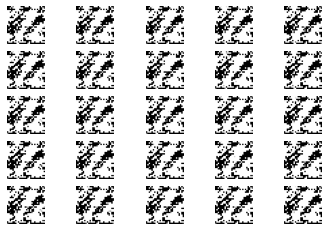

0  lossD= 0.699749561265493  lossG= 0.28578723841904  Dpos= 0.11269302  Dneg= 0.79814297
Epoch number : 1


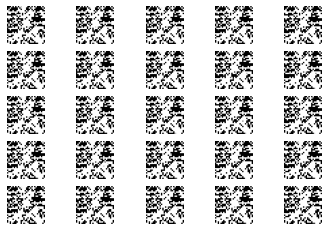

Epoch number : 2


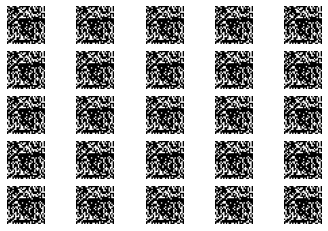

2  lossD= 0.6932811211699095  lossG= 0.6239941930159544  Dpos= 0.4811995  Dneg= 0.53530145


In [ ]:
data_generator = get_batch()
nb_epoch = 21
ones = np.ones((batch_size, 1))
#ones = 0.9*ones

zeros = np.zeros((batch_size, 1))
for epoch in range(nb_epoch):
  lossD = []
  lossG = []
  Dpos = []
  Dneg = []
  for batch in range(int(nbdata/batch_size)):

    # train discriminator with positive samples
    x = next(data_generator)
    bruit = np.random.normal(0,1,(batch_size, 28,28,1))/100.
    
    lossP = D.train_on_batch(x+bruit, ones)
    if epoch % 2 == 0:
      x = next(data_generator)
      Dpos.append( D.predict(x) )
    
    # train discriminator with negative samples
    z = np.random.normal(0,1,(batch_size, z_dim)) 

    fakes = G.predict(z)
    lossN = D.train_on_batch(fakes, zeros)
    if epoch % 2 == 0:
      z = np.random.normal(0,1,(batch_size, z_dim))
      fakes = G.predict(z)
      Dneg.append( D.predict(fakes) )
    
    # compute D's loss (for plotting)
    lossD.append((lossP + lossN) / 2.)
    
    # train generator with GAN
    z = np.random.normal(0,1,(batch_size, z_dim))
    lossG.append( GAN.train_on_batch(z, ones) )

# plotting what the generator produces
  print( "Epoch number : " + str(epoch))
  z = np.random.normal(0,1,(25, z_dim))
  fakes = G.predict(z)
  for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(fakes[i].reshape(28, 28), cmap='gray_r') #plt.imshow(fakes[i, :, :, 0], cmap='gray_r')
  plt.show()

  # Compute and store some statistics for further plotting
  if epoch % 2 == 0:
    lossD = np.mean(lossD)
    lossG = np.mean(lossG)
    Dpos = np.mean(Dpos)
    Dneg = np.mean(Dneg)
  
    lossDtab.append(lossD)
    lossGtab.append(lossG)
    Dpostab.append(Dpos)
    Dnegtab.append(Dneg)
  
    print(epoch, " lossD=", lossD, " lossG=", lossG, " Dpos=", Dpos, " Dneg=", Dneg )
  
  epochs_done = epochs_done + 1

In [ ]:
import matplotlib.pyplot as plt


ppos, = plt.plot(Dpostab, label="pos")
pneg, = plt.plot(Dnegtab, label="neg")
plt.legend(handles=[ppos, pneg])

In [ ]:
import matplotlib.pyplot as plt

z = np.random.uniform(-1,1,(25, z_dim))
fakes = G.predict(z)
print(fakes.shape)

for i in range(25):
	# define subplot
	plt.subplot(5, 5, 1 + i)
	# turn off axis
	plt.axis('off')
	# plot raw pixel data
	plt.imshow(fakes[i].reshape(28, 28), cmap='gray_r') #plt.imshow(fakes[i, :, :, 0], cmap='gray_r')
plt.show()